In [22]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import dask.dataframe as dd
import warnings
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from collections import Counter
warnings.filterwarnings("ignore")
from dask_jobqueue import SLURMCluster
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from os.path import join

In [114]:
def plot_cluster_dist(labels):
    plt.figure(figsize=(12,6))
    counts = Counter(labels)
    percent_counts = [x / sum(counts.values()) * 100 for x in counts.values()]
    sns.barplot(list(gmm_counts.keys()), gmm_percentage, palette='deep')
    plt.xlabel('Cluster')
    plt.ylabel('Percent of Storms')
    return counts

### Clustering of Neuron Activations
Note: Spectral clustering does not scale well. Using a larger amount of samples will significantly increase computational time. GMM scales well and can use all storms. 

In [14]:
data_path = '/glade/scratch/dgagne/NSC_data/track_data_nsc_3km_REFL_COM_ws_nc/'
neuron_activations = '/glade/scratch/cbecker/HWT_figures/HWT2/charlie/uh_dn6/neuron_activations_mpl_dn6_1000_train.csv'
df = pd.read_csv(neuron_activations)
n_samps = 20000
df_samp = df.sample(n_samps)

# Get neuron activations for training
X_gmm = df.iloc[:, -6:]
X_spectral = df_samp.iloc[:, -6:]

# Number of clusters to create for each method
n_clusters = 5

### Gaussian Mixture Model 
* gm_labels: cluster labels for all storms
* gm_proba: probabilities of each storm by component/cluster
* Counts of labels

In [15]:
%%time
gm = GaussianMixture(n_components=n_clusters, covariance_type='full', max_iter=1000, tol=1e-3, n_init=10).fit(X_gmm)
gm_labels = gm.predict(X)
gm_proba = gm.predict_proba(X)

# add clusters to Neuron activations
df['cluster'] = gm_labels
df['cluster_prob'] = gm_proba.max(axis=1)

CPU times: user 1min 7s, sys: 4 s, total: 1min 11s
Wall time: 1min 11s


Counter({3: 353308, 1: 179207, 0: 258494, 4: 99756, 2: 35473})

#### Plot distribution of clusters and probabilities

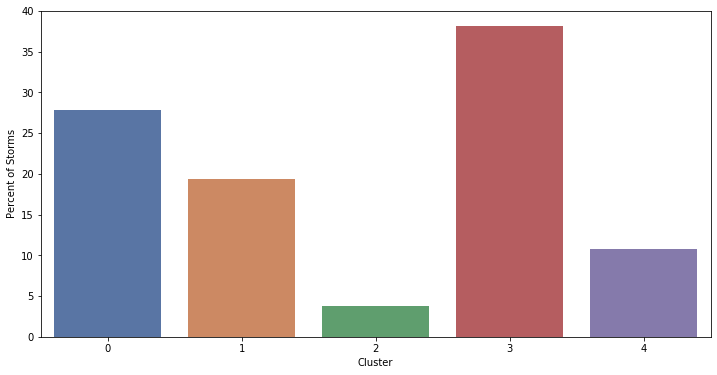

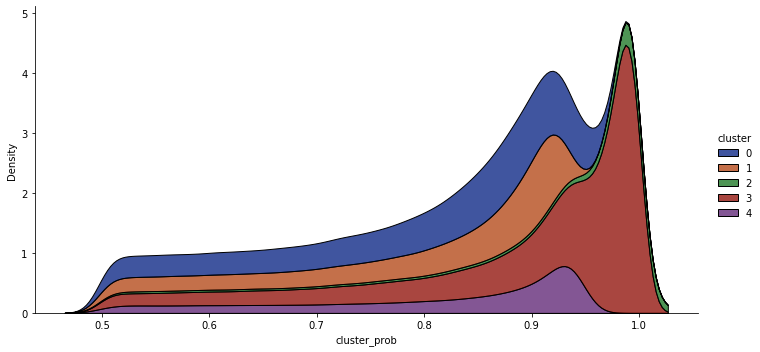

In [115]:
plot_cluster_dist(gm_labels)
sns.displot(data=df, x='cluster_prob', hue='cluster', multiple='stack', palette='dark', kind='kde', aspect=2)

### Spectral Clustering
* spectral_labels: cluster labels 
* Count of labels

In [21]:
%%time
spectral = SpectralClustering(n_clusters=n_clusters, n_jobs=-1)
spectral_labels = spectral.fit_predict(X_spectral)

df_samp['cluster'] = spectral_labels

CPU times: user 2min 13s, sys: 1min 27s, total: 3min 40s
Wall time: 13min 21s


Counter({0: 5927, 3: 5337, 4: 6943, 1: 1582, 2: 211})

Counter({0: 5927, 3: 5337, 4: 6943, 1: 1582, 2: 211})

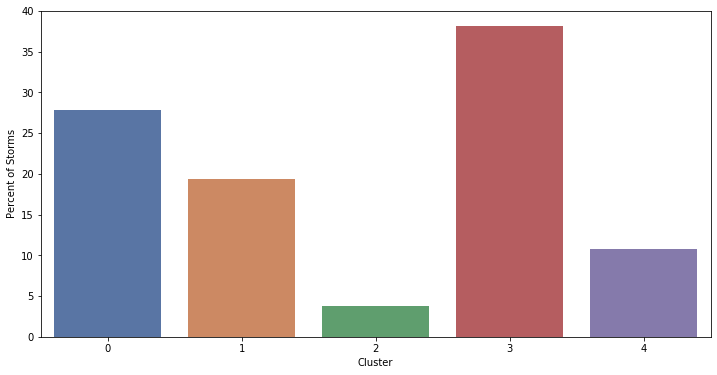

In [116]:
plot_cluster_dist(spectral_labels)

In [117]:
# Add dataframes to dictionary for plotting
cluster_dfs = {'GMM': df, 'Spectral': df_samp}

#### Plotting options:
* **cluster_method**: 'GMM' or 'Spectral'
* **n_storms**: Must be an even square (4, 9, 16, 25)
* **gmm_storm_probabilities**: Which probability storm to plot. 'Highest', 'Lowest', 'Random'
* **save_figures**: Boolean
* **save_out_path**: Base path to save figures (if True)

In [31]:
cluster_method = 'Spectral'
n_storms = 16
gmm_storm_probabilities = 'highest'
save_figures = False
save_out_path = '/glade/scratch/cbecker/'

CPU times: user 2min 59s, sys: 13 s, total: 3min 12s
Wall time: 3min 49s


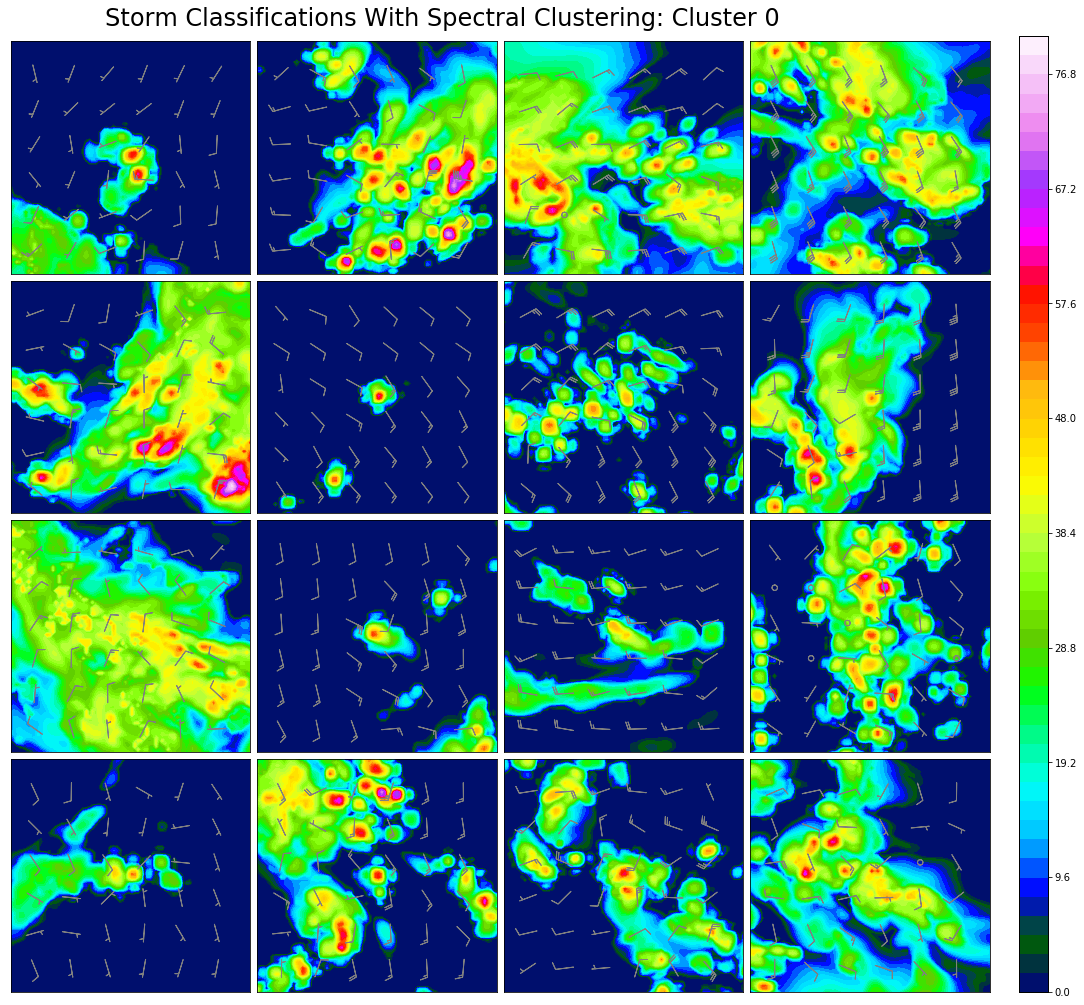

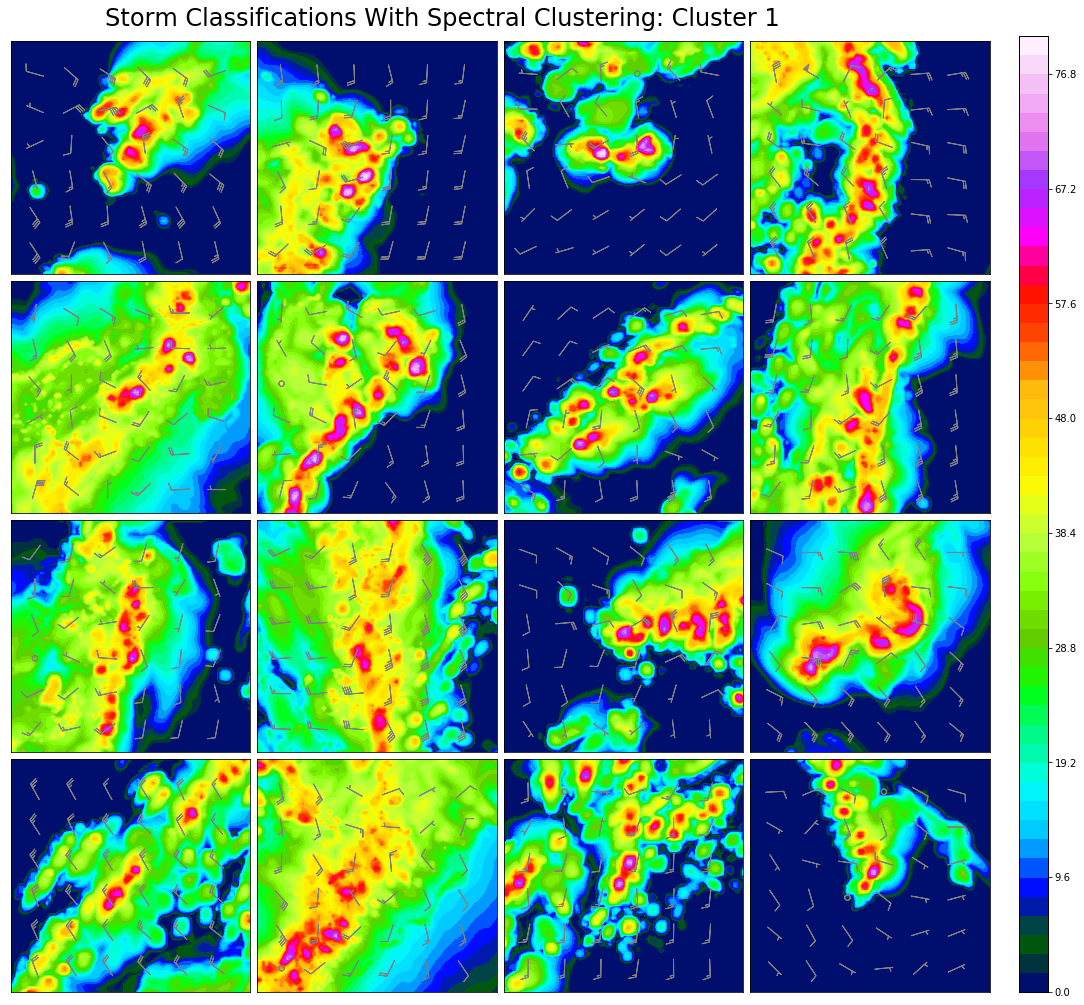

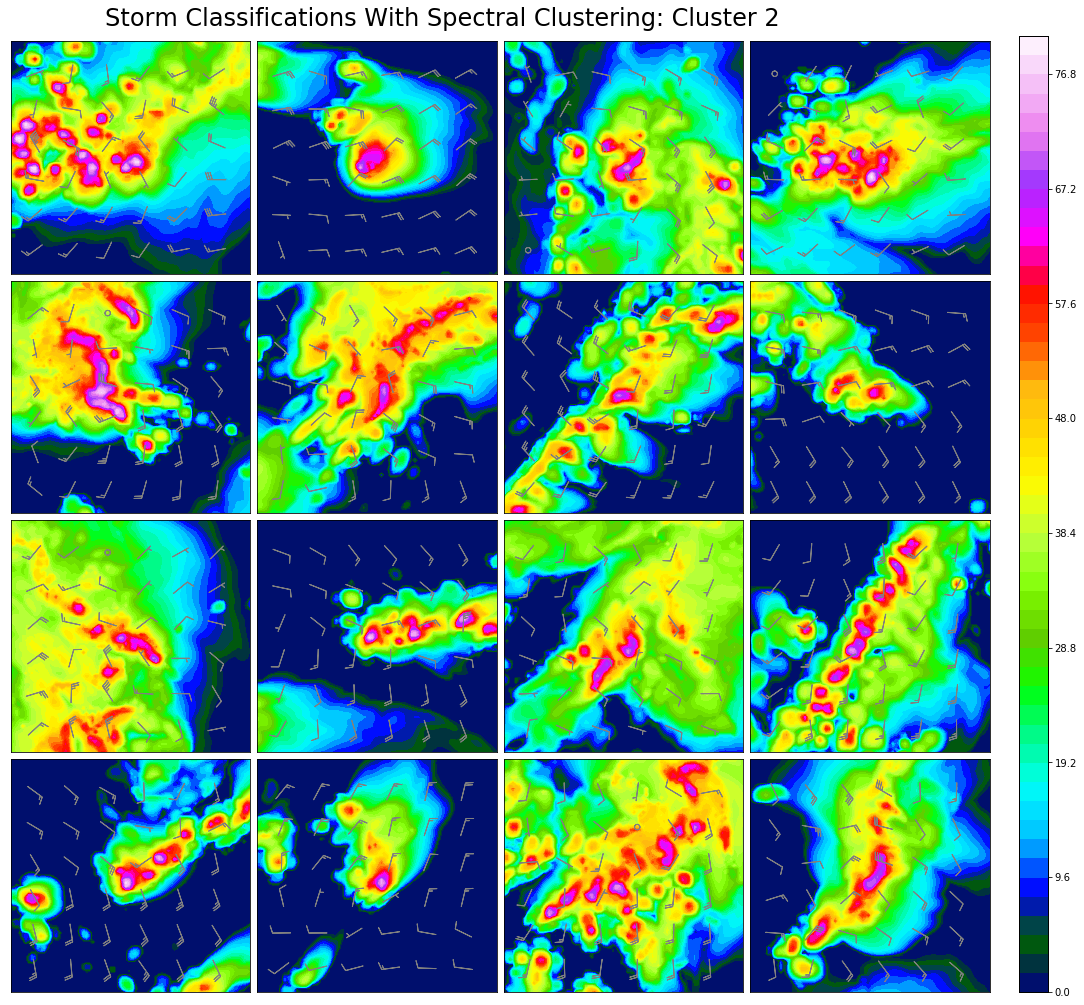

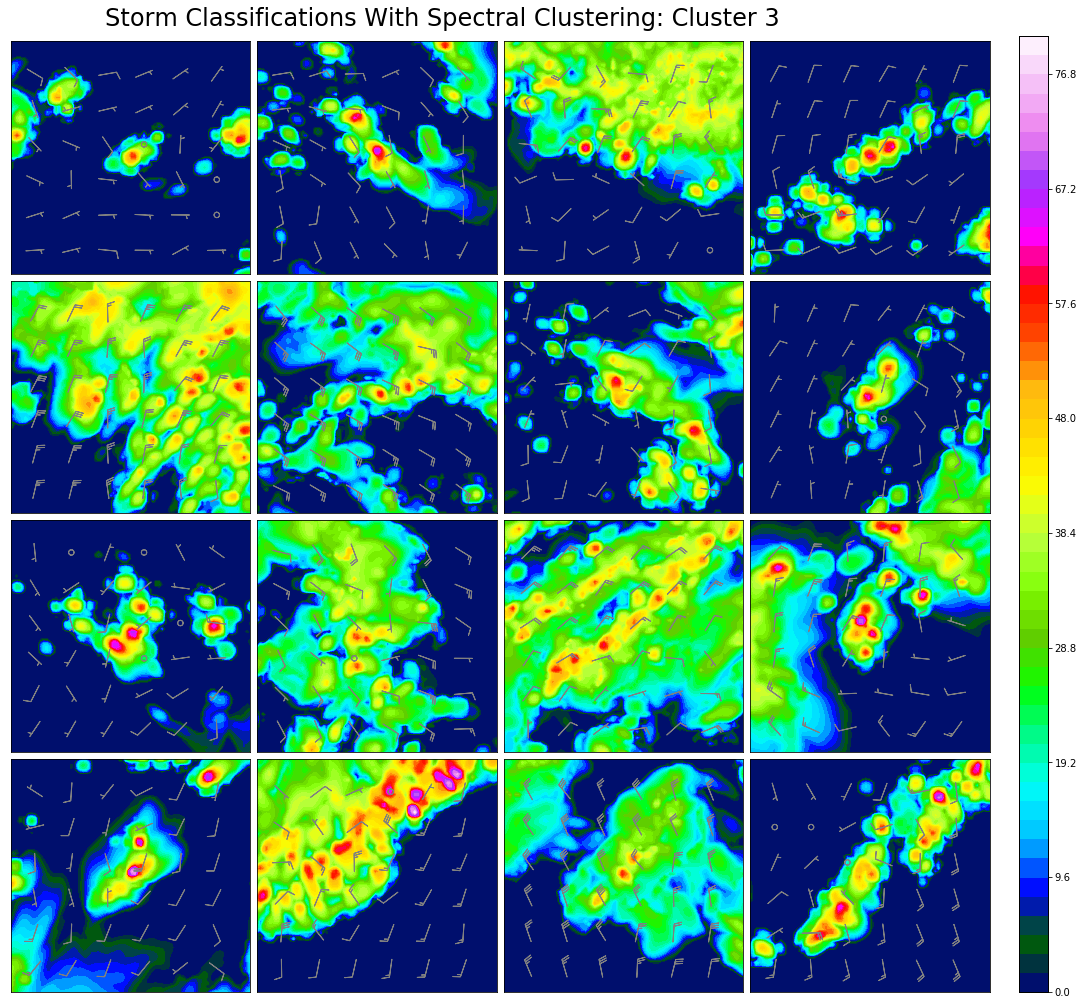

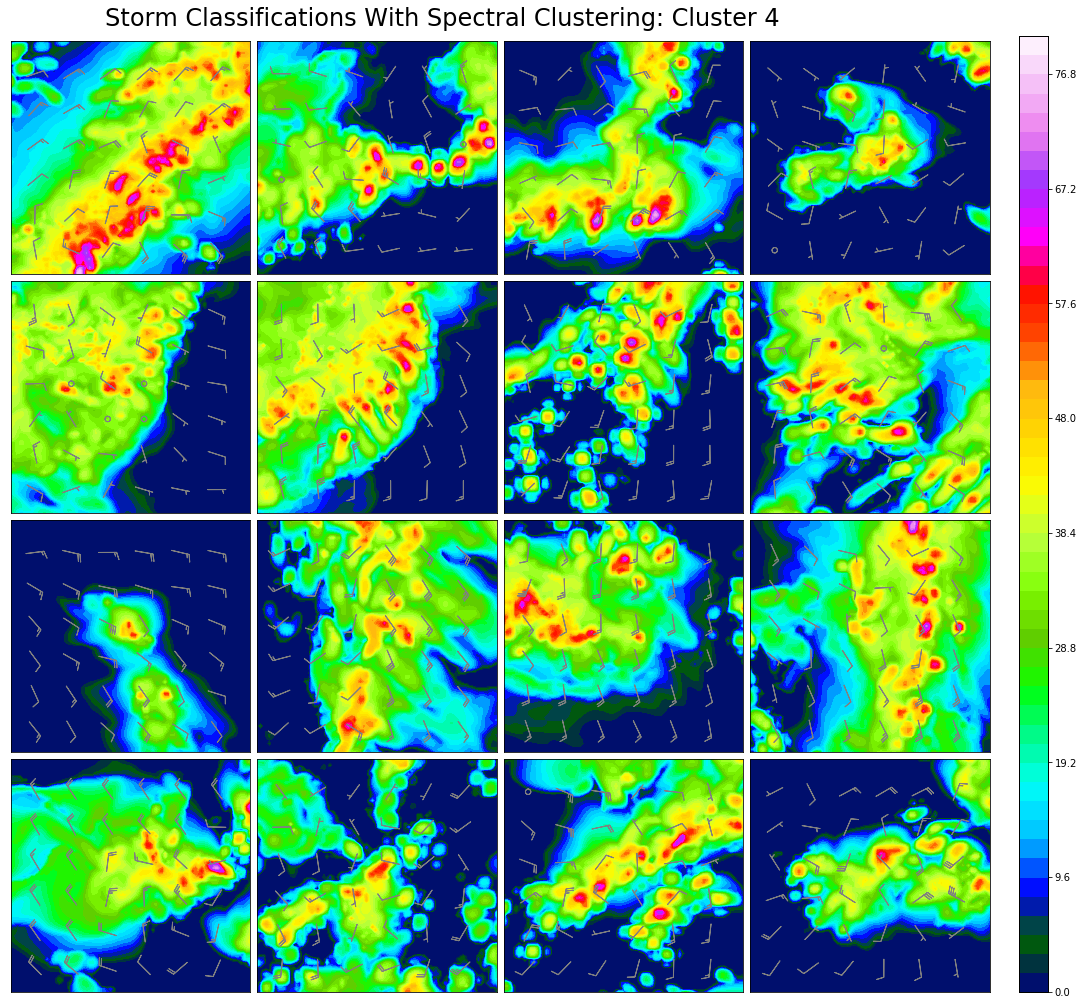

In [32]:
%%time
ms_mph = 2.237 # conversion from m/s to mph
cluster_df = cluster_dfs[cluster_method]

for cluster in range(cluster_df['cluster'].nunique()):
    
    if cluster_method == 'Spectral':
        sub = cluster_df[cluster_df['cluster'] == cluster].sample(n_storms).reset_index(drop=False)
    elif cluster_method == 'GMM':
        if gmm_storm_probabilities == 'highest':
            sub = cluster_df[cluster_df['cluster'] == cluster].sort_values(['cluster_prob'], ascending=True)[:n_storms].reset_index(drop=True)
        elif gmm_storm_probabilities == 'lowest':
            sub = cluster_df[cluster_df['cluster'] == cluster].sort_values(['cluster_prob'], ascending=False)[:n_storms].reset_index(drop=True)
        else:
            sub = cluster_df[cluster_df['cluster'] == cluster].sample(n_storms).reset_index(drop=False)
            
    date = sub['run_date'].astype('datetime64').reset_index(drop=True)
    fig, axes = plt.subplots(int(np.sqrt(n_storms)), int(np.sqrt(n_storms)) , figsize=(16, 16), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.03, hspace=0.03)

    for i, ax in enumerate(axes.ravel()):
        date_string = date[i].strftime('%Y%m%d')
        file_path = f'{data_path}/NCARSTORM_{date_string}-0000_d01_model_patches.nc'
        ds = xr.open_dataset(file_path)
        
        x = ds[['REFL_COM_curr', 'U10_curr', 'V10_curr']].where((ds.centroid_i == sub['centroid_i'][i])&(ds.centroid_j == sub['centroid_j'][i]), drop=True)
        
        wind_slice = (slice(8, None, 12), slice(8, None, 12))
        x_mesh, y_mesh = np.meshgrid(range(len(ds['row'])), range(len(ds['col'])))
        
        im = ax.contourf(x['REFL_COM_curr'][0], levels=np.linspace(0, 80, 51), vmin=0, vmax=80, cmap='gist_ncar')
        ax.barbs(x_mesh[wind_slice], y_mesh[wind_slice],  x['U10_curr'][0][wind_slice] * ms_mph, x['V10_curr'][0][wind_slice] * ms_mph, color='grey', pivot='middle', length=6)
        
        if cluster_method == 'GMM':
            ax.text(3, 4, f"P = {np.round(sub.loc[i]['cluster_prob'], 4)}", style='italic', fontsize=12, bbox={'facecolor': 'lightgrey', 'alpha': 0.8, 'pad': 10})
            
        plt.subplots_adjust(right=0.975)
        cbar_ax = fig.add_axes([1, 0.125, 0.025, 0.83])
        fig.colorbar(im, cbar_ax)
        ax.set_xticks([], [])
        ax.set_yticks([], [])
        plt.suptitle(f'Storm Classifications With {cluster_method} Clustering: Cluster {cluster}', fontsize=24)
        plt.subplots_adjust(top=0.95)
        if save_figures:
            if cluster_method == 'Spectral':
                plt.savefig(join(save_out_path, f'{cluster_method}_{n_clusters}_{cluster}.png', bbox_inches='tight'))
            else:
                plt.savefig(join(save_out_path, f'{cluster_method}_{n_clusters}_{cluster}_{gmm_storm_probabilities}.png', bbox_inches='tight'))